In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import os
import pandas as pd

In [2]:
# Open the JSON file
with open('DataCollection/LeanTheorems.json') as f:
    # Load the JSON data into a Python dictionary
    theorem_data = json.load(f)

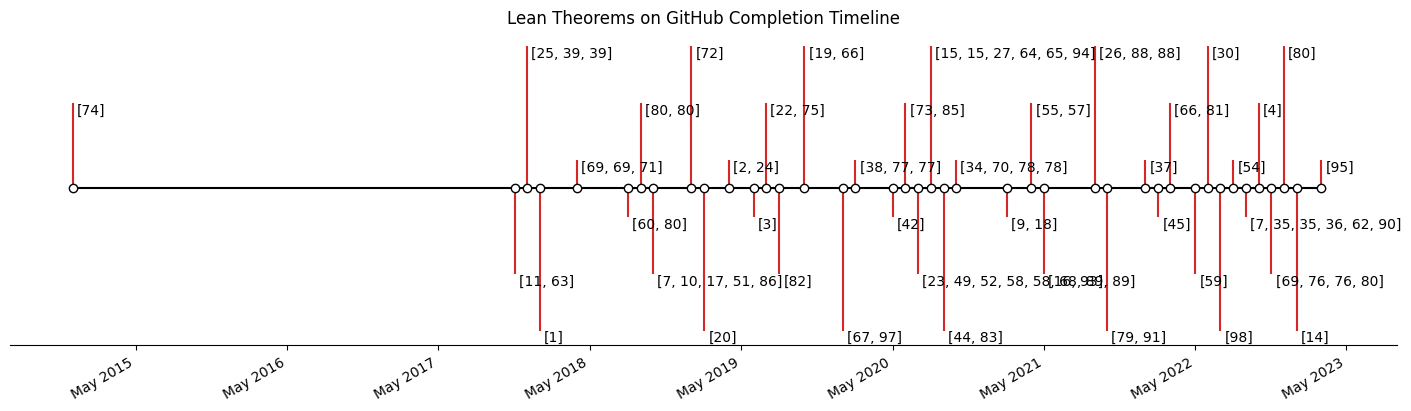

In [3]:
#################################
#### latest activity timeline ###
#################################
commits = []
last_commit_date =  []
names = []
for element in theorem_data:
    if isinstance(element, dict):
        for sources in element['sources']:
            if 'commits' in sources:
                commit = sources['commits']
                count = len(commit)
                if len(commit) > 0:
                    # Only append to plot if it has commits
                    commits.append(count)
                    names.append(element['theorem_number'])
                    last_commit_date.append(commit[len(commit) - 1]['date'])
    else:
        print("Each element in the JSON file must be a dictionary.")

# Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S%z") for d in last_commit_date]

# Create a dataframe
df = pd.DataFrame({'Commits': commits, 'Dates': dates, 'Names': names})
# Localize time zones
df['Dates'] = pd.to_datetime(df['Dates'], utc=True)
df['Dates'] = df['Dates'].dt.tz_convert('US/Eastern')
# Bin dataframe by month
bins = pd.date_range(start=df['Dates'].min() - timedelta(days=1) , end=df['Dates'].max() + timedelta(days=31) , freq='M')
df['bins'] = pd.cut(x=df['Dates'], bins=bins, labels = [d.strftime('%b-%Y') for d in bins][:-1], include_lowest=True)
# Aggregate bins
agg = df.groupby('bins')['Names'].aggregate(list)

# Choose some nice levels
map = np.tile([-5, 5, -3, 3, -1, 1], int(np.ceil(len(agg)/6)))[:len(agg)]
levels = []
present_bins = []
for idx in range(len(agg)):
    if (len(agg[idx])) > 0:
        levels.append(map[-1])
        map = map[:-1]
        present_bins.append(bins[idx])
    else:
        levels.append(0)
levels.append(0)

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(14, 4), layout="constrained")
ax.set(title="Lean Theorems on GitHub Completion Timeline")

ax.vlines(bins, ymin=0, ymax=levels, color="tab:red")  # The vertical stems.
ax.plot(present_bins, np.zeros_like(present_bins), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.

# annotate lines
for d, l, r in zip(bins, levels, agg):
    if (len(r) > 0):
        ax.annotate(r, xy=(d, l),
                    xytext=(3, 0), textcoords="offset points",
                    rotation=0,
                    horizontalalignment="left",
                    verticalalignment="top")

# format x-axis with 4-month intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")


# remove y-axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

In [4]:
# Get the list of theorems that have been implemented multiple times
for element in theorem_data:
    if isinstance(element, dict):
        if (len(element['sources']) > 1):
                print(element['theorem_number'])
    else:
        print("Each element in the JSON file must be a dictionary.")

7
15
35
39
58
66
69
76
77
78
80
88
89


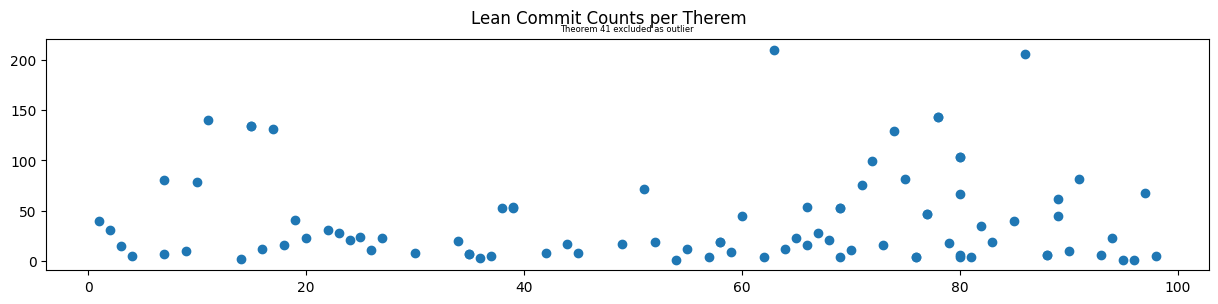

In [5]:
#################################
#### Commit Counts per Therem ###
#################################

# These are here because of a JSON bug in theorem 96 of Lean.
names.append(96)
commits.append(1)
commits_copy = commits
# # Plot a histogram of the lengths using matplotlib
plt.figure(figsize=(15, 3))
plt.scatter(names, commits)
plt.suptitle('Lean Commit Counts per Therem\n')
plt.title('\nTheorem 41 excluded as outlier', fontsize = 6)
plt.show()

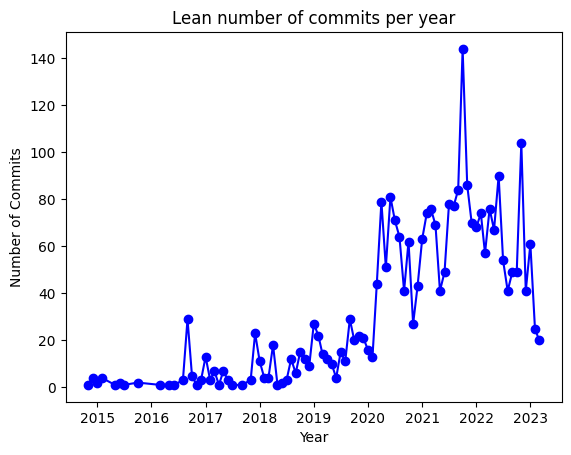

In [6]:
#################################
#### Number of Commits over time ###
#################################
dates = []
# Loop through each element in the list
for element in theorem_data:
    # Check if the element is a dictionary
    if isinstance(element, dict):
        # Get the length of the dictionary (i.e., the number of key-value pairs)
        sources = element['sources'][0]
        if 'commits' in sources:
            commits = sources['commits']
            if len(commits) > 0:
                for commit in commits:
                    dates.append(datetime.strptime(commit['date'], "%Y-%m-%dT%H:%M:%S%z"))
    else:
        # If it's not a dictionary, print an error message
        print("Each element in the JSON file must be a dictionary.")
# Count the number of commits per month of each year
counts = {}
for date in dates:
    year_month = date.strftime("%Y-%m")
    if year_month in counts:
        counts[year_month] += 1
    else:
        counts[year_month] = 1


# Sort the counts by year and month
counts = dict(sorted(counts.items()))
# Extract the years and months from the keys and values
x_values = [datetime.strptime(year_month, "%Y-%m") for year_month in counts.keys()]
y_values = list(counts.values())

# Create a timeline plot with the counts
fig, ax = plt.subplots()
ax.plot_date(x_values, y_values, fmt="bo-", xdate=True, ydate=False)

# Set the x-axis tick labels to show the year and month
date_formatter = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_formatter)
ax.set_xlabel("Year")
ax.set_ylabel("Number of Commits")
ax.set(title= "Lean number of commits per year")
plt.show()

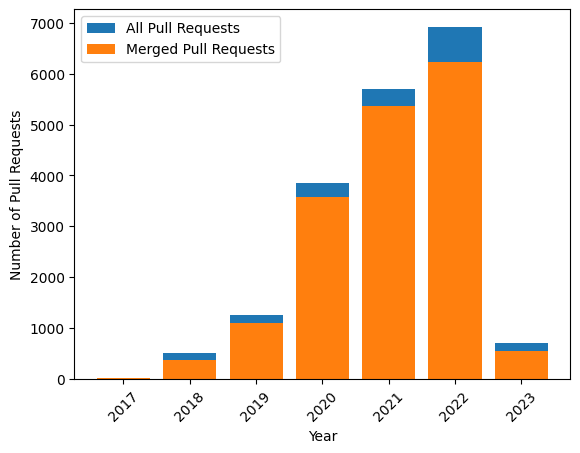

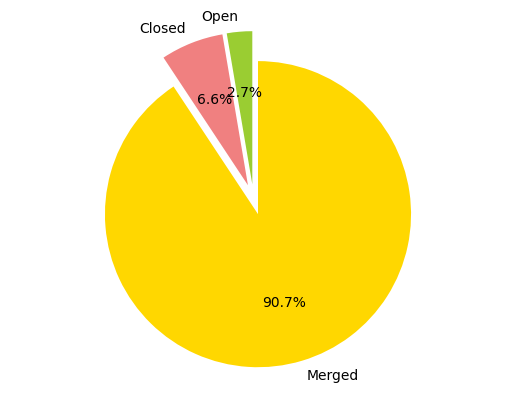

In [7]:
lean_pr_data = []
with open('DataCollection/leanprover-community_lean_PullRequests.json') as f_lean_pr:
    lean_pr = json.load(f_lean_pr)
    lean_pr_data.extend(lean_pr)

with open('DataCollection/leanprover-community_mathlib_PullRequests.json') as f_mathlib_is:
    # Load the JSON data into a Python dictionary
    mathlib_prs = json.load(f_mathlib_is)
    lean_pr_data.extend(mathlib_prs)

pull_dates= []
merge_dates= []
open_count = 0
closed_count = 0
merged_count =0

for element in lean_pr_data:
    pull_dates.append(datetime.strptime(element['open_date'], "%Y-%m-%dT%H:%M:%S%z"))
    if element['state'] == 'open':
        open_count += 1
    elif element['state'] == 'merged':
        merged_count += 1
        merge_dates.append(datetime.strptime(element['open_date'], "%Y-%m-%dT%H:%M:%S%z"))
    elif element['state'] == 'closed':
        x = element['discussion']
        getborsd = False
        for i in x :
            if i['author'] == 'bors[bot]' :
                msg = i['comment']
                txt = 'Pull request successfully merged into master.'
                if os.path.commonprefix([msg,txt]) == txt :
                    #print("bors detected")
                    merged_count += 1
                    merge_dates.append(datetime.strptime(element['open_date'], "%Y-%m-%dT%H:%M:%S%z"))
                    getborsd = True
        if not(getborsd) :
            closed_count += 1

# Count the number of pull requests and merged pull requests per year
pull_counts = {}
merge_counts = {}
for date in pull_dates:
    year = date.strftime("%Y")
    if year in pull_counts:
        pull_counts[year] += 1
    else:
        pull_counts[year] = 1
for date in merge_dates:
    year = date.strftime("%Y")
    if year in merge_counts:
        merge_counts[year] += 1
    else:
        merge_counts[year] = 1

# Sort the counts by year
pull_counts = dict(sorted(pull_counts.items()))
merge_counts = dict(sorted(merge_counts.items()))
# Extract the years from the keys and values
y_pull_values = list(pull_counts.values())
y_merge_values = []
for year in pull_counts.keys():
    if year in merge_counts:
        y_merge_values.append(merge_counts[year])
    else:
        y_merge_values.append(0)

# Create a line chart with the counts
fig, ax = plt.subplots()
#ax.plot_date(x_values, y_pull_values, fmt="bo-", xdate=True, ydate=False, label="All Pull Requests")
#ax.plot_date(x_values, y_merge_values, fmt="bo-", xdate=True, ydate=False, label="All Pull Requests")
ax.bar(pull_counts.keys(), y_pull_values, label="All Pull Requests")
ax.bar(pull_counts.keys(), y_merge_values, label="Merged Pull Requests")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Pull Requests")
# ax.set(title= "Lean all pull requests and merged pull requests per year")
ax.legend()
plt.xticks(rotation=45)
# plt.show()

# Create a pie chart with the counts
labels = ["Open", "Closed", "Merged"]
sizes = [open_count, closed_count, merged_count]
colors = ["yellowgreen", "lightcoral", "gold"]
explode = (0.1, 0.1, 0.1)  # explode the Open slice
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
ax.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
# ax.set_title("Lean Pull Request State")
plt.show()

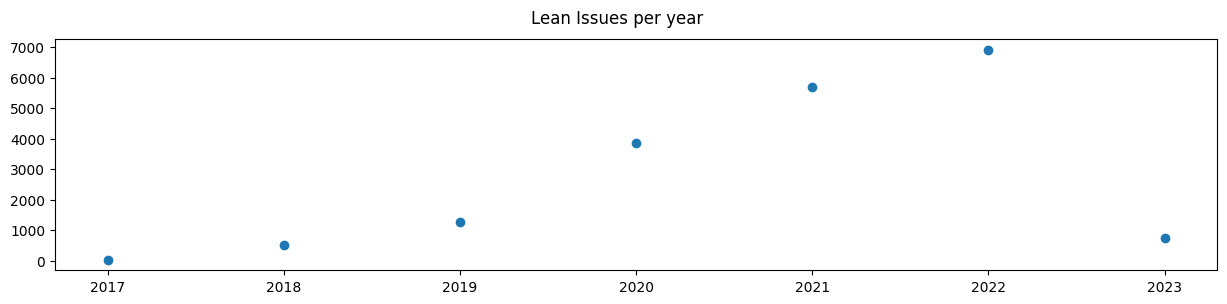

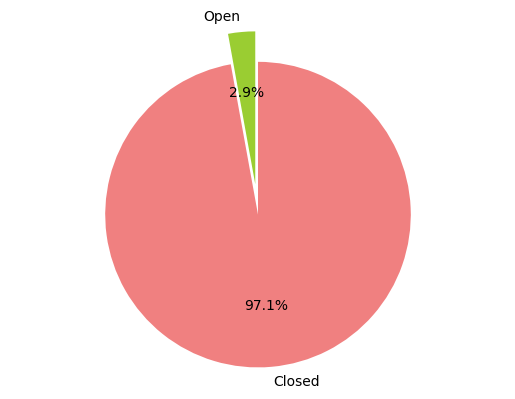

In [8]:
#################################
#### Issues###
#################################

lean_issue_data = []

with open('DataCollection/leanprover-community_lean_Issues.json') as f_lean_is:
    # Load the JSON data into a Python dictionary
    lean_issues = json.load(f_lean_is)
    lean_issue_data.extend(lean_issues)

with open('DataCollection/leanprover-community_mathlib_Issues.json') as f_mathlib_is:
    # Load the JSON data into a Python dictionary
    mathlib_issues = json.load(f_mathlib_is)
    lean_issue_data.extend(mathlib_issues)


issues_dates= []
open_issue_count = 0
closed_issue_count = 0

for element in lean_issue_data:
    issues_dates.append(datetime.strptime(element['open_date'], "%Y-%m-%dT%H:%M:%S%z"))
    if element['state'] == 'open':
        open_issue_count += 1
    elif element['state'] == 'closed':
        closed_issue_count += 1

# Count the number of pull requests and merged pull requests per year
issue_counts = {}

for date in issues_dates:
    year = date.strftime("%Y")
    if year in issue_counts:
        # print('issue incremented\n')
        issue_counts[year] = issue_counts.get(year, 0) + 1
    else:
        # print('issue initialized\n')
        issue_counts[year] = 1

# Sort the counts by year
issue_counts = dict(sorted(issue_counts.items()))
plt.figure(figsize=(15, 3))
plt.scatter(issue_counts.keys(), issue_counts.values())
plt.suptitle("Lean Issues per year")
# plt.show()

# Create a pie chart with the counts
labels = ["Open", "Closed"]
sizes = [open_issue_count, closed_issue_count]
colors = ["yellowgreen", "lightcoral"]
explode = (0.1, 0.1)  # explode the Open slice
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
ax.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
# ax.set_title("Lean Issues State")
plt.show()

In [34]:
# Find the number of unique contributors 
# Unique contributors are anyone who has committed or participated in and issue or pull request

# Lean Lang Issues
with open('DataCollection/leanprover-community_lean_Issues.json') as f_lean_is:
    lean_issues = json.load(f_lean_is)
df = pd.DataFrame(lean_issues)
df['open_date'] = pd.to_datetime(df['open_date'])
df['year'] = df['open_date'].dt.year
issue_comments_list_lang = []
issues_list_lang = []
for i, row in df.iterrows():
    for comment in row['discussion']:
        comment_year = pd.to_datetime(comment['date']).year
        issue_comments_list_lang.append({'author': comment['author'], 'year': comment_year})
    issues_list_lang.append({'author': row['author'], 'year': row['year']})
issue_comment_authors_lang = pd.DataFrame(issue_comments_list_lang)
issue_authors_lang = pd.DataFrame(issues_list_lang)

# Lean Mathlib Issues
with open('DataCollection/leanprover-community_mathlib_Issues.json') as f_mathlib_is:
    mathlib_issues = json.load(f_mathlib_is)
df = pd.DataFrame(mathlib_issues)
df['open_date'] = pd.to_datetime(df['open_date'])
df['year'] = df['open_date'].dt.year
issue_comments_list_lib = []
issues_list_lib = []
for i, row in df.iterrows():
    for comment in row['discussion']:
        comment_year = pd.to_datetime(comment['date']).year
        issue_comments_list_lib.append({'author': comment['author'], 'year': comment_year})
    issues_list_lib.append({'author': row['author'], 'year': row['year']})
issue_comment_authors_lib = pd.DataFrame(issue_comments_list_lib)
issue_authors_lib = pd.DataFrame(issues_list_lib)

# Lean Lang PRs
with open('DataCollection/leanprover-community_lean_PullRequests.json') as f_lean_pr:
    lean_prs = json.load(f_lean_pr)
df = pd.DataFrame(lean_prs)
df['open_date'] = pd.to_datetime(df['open_date'])
df['year'] = df['open_date'].dt.year
pr_comments_list_lang = []
prs_list_lang = []
for i, row in df.iterrows():
    for comment in row['discussion']:
        comment_year = pd.to_datetime(comment['date']).year
        pr_comments_list_lang.append({'author': comment['author'], 'year': comment_year})
    prs_list_lang.append({'author': row['author'], 'year': row['year']})
pr_comment_authors_lang = pd.DataFrame(pr_comments_list_lang)
pr_authors_lang = pd.DataFrame(prs_list_lang)

# Lean Library PRs
with open('DataCollection/leanprover-community_mathlib_PullRequests.json') as f_mathlib_is:
    mathlib_prs = json.load(f_mathlib_is)
df = pd.DataFrame(mathlib_prs)
df['open_date'] = pd.to_datetime(df['open_date'])
df['year'] = df['open_date'].dt.year
pr_comments_list_lib = []
prs_list_lib = []
for i, row in df.iterrows():
    for comment in row['discussion']:
        comment_year = pd.to_datetime(comment['date']).year
        pr_comments_list_lib.append({'author': comment['author'], 'year': comment_year})
    prs_list_lib.append({'author': row['author'], 'year': row['year']})
pr_comment_authors_lib = pd.DataFrame(pr_comments_list_lib)
pr_authors_lib = pd.DataFrame(prs_list_lib)

# Lean lang commits
with open('DataCollection/Lean_leanprover-community_lean_Commits.json') as f:
    lean_commits = json.load(f)
df = pd.DataFrame(lean_commits)
df['date'] = pd.to_datetime(df['date'], utc=True)
display(df['date'].dtype)
df['year'] = df['date'].dt.year
commits_list_lang = []
for i, row in df.iterrows():
    commits_list_lang.append({'author': row['author'], 'year': row['year']})
commit_authors_lang = pd.DataFrame(commits_list_lang)

# Lean lib commits
with open('DataCollection/Lean_leanprover-community_mathlib_Commits.json') as f:
    mathlib_commits = json.load(f)
df = pd.DataFrame(mathlib_commits)
df['date'] = pd.to_datetime(df['date'], utc=True)
display(df['date'].dtype)
df['year'] = df['date'].dt.year
commits_list_lib = []
for i, row in df.iterrows():
    commits_list_lib.append({'author': row['author'], 'year': row['year']})
commit_authors_lib = pd.DataFrame(commits_list_lib)

# Create arrays of unique authors by year
icua_lean_lang = issue_comment_authors_lang.groupby('year')['author'].nunique()
iua_lean_lang = issue_authors_lang.groupby('year')['author'].nunique()
prcua_lean_lang = pr_comment_authors_lang.groupby('year')['author'].nunique()
prua_lean_lang = pr_authors_lang.groupby('year')['author'].nunique()
cua_lean_lang = commit_authors_lang.groupby('year')['author'].nunique()
icua_lean_lib = issue_comment_authors_lib.groupby('year')['author'].nunique()
iua_lean_lib = issue_authors_lib.groupby('year')['author'].nunique()
prcua_lean_lib = pr_comment_authors_lib.groupby('year')['author'].nunique()
prua_lean_lib = pr_authors_lib.groupby('year')['author'].nunique()
cua_lean_lib = commit_authors_lib.groupby('year')['author'].nunique()

datetime64[ns, UTC]

datetime64[ns, UTC]

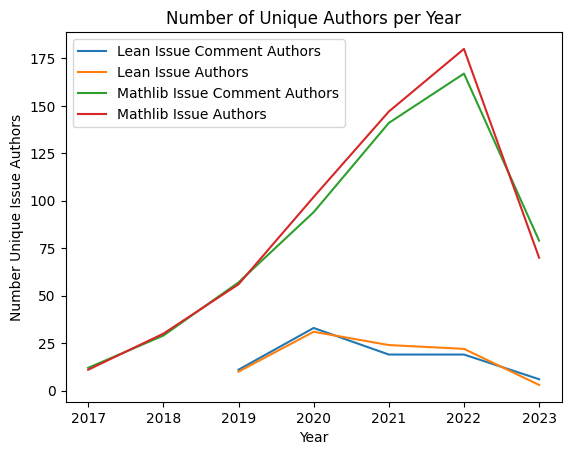

In [36]:
icua_lean_lang.plot(kind='line', label='Lean Issue Comment Authors')
iua_lean_lang.plot(kind='line', label='Lean Issue Authors')
icua_lean_lib.plot(kind='line', label='Mathlib Issue Comment Authors')
iua_lean_lib.plot(kind='line', label='Mathlib Issue Authors')
plt.xlabel('Year')
plt.ylabel('Number Unique Issue Authors')
plt.title('Number of Unique Authors per Year')
plt.legend()
plt.show()

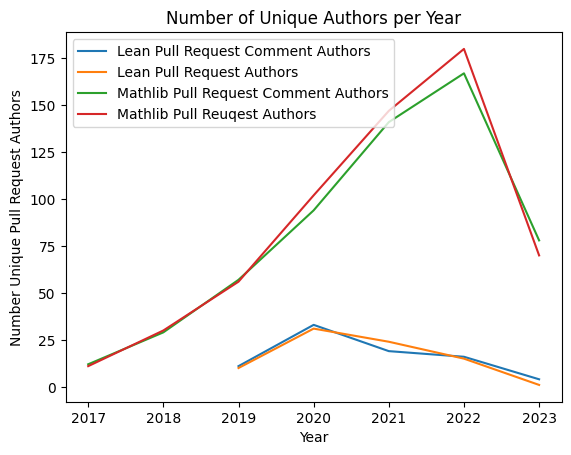

In [37]:
prcua_lean_lang.plot(kind='line', label='Lean Pull Request Comment Authors')
prua_lean_lang.plot(kind='line', label='Lean Pull Request Authors')
prcua_lean_lib.plot(kind='line', label='Mathlib Pull Request Comment Authors')
prua_lean_lib.plot(kind='line', label='Mathlib Pull Reuqest Authors')
plt.xlabel('Year')
plt.ylabel('Number Unique Pull Request Authors')
plt.title('Number of Unique Authors per Year')
plt.legend()
plt.show()

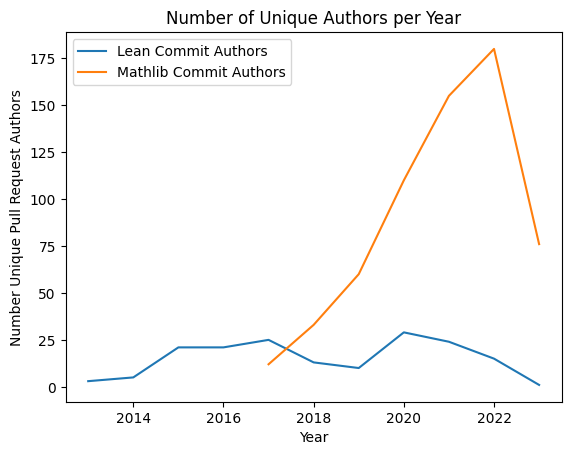

In [38]:
cua_lean_lang.plot(kind='line', label='Lean Commit Authors')
cua_lean_lib.plot(kind='line', label='Mathlib Commit Authors')
plt.xlabel('Year')
plt.ylabel('Number Unique Pull Request Authors')
plt.title('Number of Unique Authors per Year')
plt.legend()
plt.show()

In [39]:
# Alternative Implementation of the Above
# Find the number of unique contributors 
# Unique contributors are anyone who has committed or participated in and issue or pull request

# Lean Lang Issues + Pull Requests
ispr_lang = []
with open('DataCollection/leanprover-community_lean_Issues.json') as f_lean_is:
    ispr_lang = json.load(f_lean_is)
with open('DataCollection/leanprover-community_lean_PullRequests.json') as f_lean_pr:
    ispr_lang.extend(json.load(f_lean_pr))
df = pd.DataFrame(ispr_lang)
df['open_date'] = pd.to_datetime(df['open_date'])
df['year'] = df['open_date'].dt.year
ispr_comments_lang = []
ispr_list_lang = []
for i, row in df.iterrows():
    for comment in row['discussion']:
        comment_year = pd.to_datetime(comment['date']).year
        ispr_comments_lang.append({'author': comment['author'], 'year': comment_year})
    ispr_list_lang.append({'author': row['author'], 'year': row['year']})
ispr_comment_authors_lang = pd.DataFrame(ispr_comments_lang)
ispr_authors_lang = pd.DataFrame(ispr_list_lang)

# Lean Mathlib Issues + Pull Requests
ispr_lib = []
with open('DataCollection/leanprover-community_mathlib_Issues.json') as f_mathlib_is:
    ispr_lib = json.load(f_mathlib_is)
with open('DataCollection/leanprover-community_mathlib_PullRequests.json') as f_mathlib_is:
    ispr_lib.extend(json.load(f_mathlib_is))
df = pd.DataFrame(ispr_lib)
df['open_date'] = pd.to_datetime(df['open_date'])
df['year'] = df['open_date'].dt.year
ispr_comments_lib = []
ispr_lib= []
for i, row in df.iterrows():
    for comment in row['discussion']:
        comment_year = pd.to_datetime(comment['date']).year
        ispr_comments_lib.append({'author': comment['author'], 'year': comment_year})
    ispr_lib.append({'author': row['author'], 'year': row['year']})
ispr_comment_authors_lib = pd.DataFrame(ispr_comments_lib)
ispr_authors_lib = pd.DataFrame(ispr_lib)

# Lean lang commits
with open('DataCollection/Lean_leanprover-community_lean_Commits.json') as f:
    lean_commits = json.load(f)
df = pd.DataFrame(lean_commits)
df['date'] = pd.to_datetime(df['date'], utc=True)
display(df['date'].dtype)
df['year'] = df['date'].dt.year
commits_list_lang = []
for i, row in df.iterrows():
    commits_list_lang.append({'author': row['author'], 'year': row['year']})
commit_authors_lang = pd.DataFrame(commits_list_lang)

# Lean lib commits
with open('DataCollection/Lean_leanprover-community_mathlib_Commits.json') as f:
    mathlib_commits = json.load(f)
df = pd.DataFrame(mathlib_commits)
df['date'] = pd.to_datetime(df['date'], utc=True)
display(df['date'].dtype)
df['year'] = df['date'].dt.year
commits_list_lib = []
for i, row in df.iterrows():
    commits_list_lib.append({'author': row['author'], 'year': row['year']})
commit_authors_lib = pd.DataFrame(commits_list_lib)

# Create arrays of unique authors by year
ispr_comments_lang = ispr_comment_authors_lang.groupby('year')['author'].nunique()
ispr_comments_lib = ispr_comment_authors_lib.groupby('year')['author'].nunique()
ispr_lang = ispr_authors_lang.groupby('year')['author'].nunique()
ispr_lib = ispr_authors_lib.groupby('year')['author'].nunique()
cua_lean_lang = commit_authors_lang.groupby('year')['author'].nunique()
cua_lean_lib = commit_authors_lib.groupby('year')['author'].nunique()

datetime64[ns, UTC]

datetime64[ns, UTC]

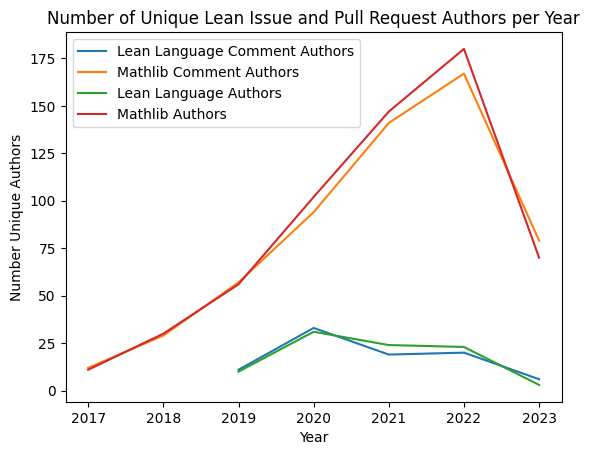

In [42]:
ispr_comments_lang.plot(kind='line', label='Lean Language Comment Authors')
ispr_comments_lib.plot(kind='line', label='Mathlib Comment Authors')
ispr_lang.plot(kind='line', label='Lean Language Authors')
ispr_lib.plot(kind='line', label='Mathlib Authors')
plt.xlabel('Year')
plt.ylabel('Number Unique Authors')
plt.title('Number of Unique Lean Issue and Pull Request Authors per Year')
plt.legend()
plt.show()

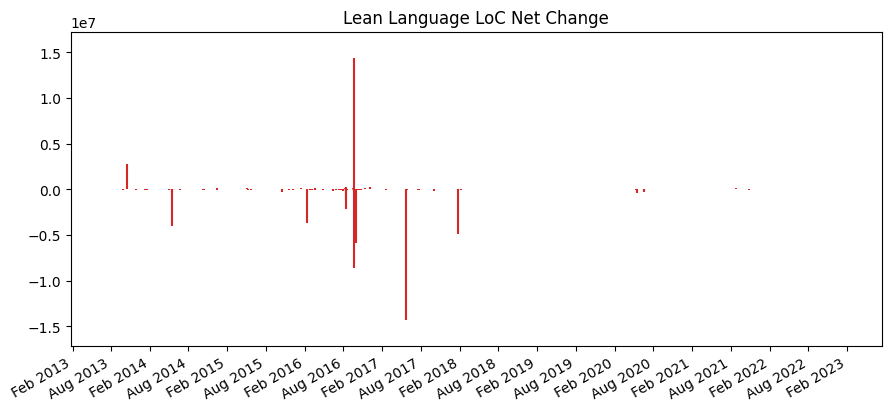

In [62]:
# Find the change in the total size of Mathlib and Lean

# Lean lang commits
with open('DataCollection/Lean_leanprover-community_lean_Commits.json') as f:
    lean_commits = json.load(f)
df = pd.DataFrame(lean_commits)
df['date'] = pd.to_datetime(df['date'], utc=True)
dates = []
nets = []
for idx, row in df.iterrows():
    net = 0
    diffs = row['diff']
    for diff in diffs:
        net += diff['additions']
        net -= diff['deletions']
    dates.append(row['date'])
    nets.append(net)

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(8.8, 4), layout="constrained")
ax.set(title="Lean Language LoC Net Change")

ax.vlines(dates, 0, nets, color="tab:red")


# format x-axis with 6-month intervals
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
ax.set_ylabel('LoC Change')

ax.margins(y=0.1)
plt.show()
    